# Recommendation System with lightGCN

LightGCN is a recommendation system model based on **graph convolutional networks** that simplifies the design of traditional graph convolutional networks, focusing on linear propagation and neighbor aggregation to improve efficiency and performance. Specifically, it learns the representations of users and items through the user-item interaction graph, removing the nonlinear transformations and weights found in traditional graph convolutional networks. This simplification of the learning process allows the model to focus more on learning high-quality embeddings of users and items.

The original model is proposed in this [paper](https://paperswithcode.com/paper/lightgcn-simplifying-and-powering-graph/review/) and the reference of this notebook can be found [here](https://www.kaggle.com/code/dipanjandas96/lightgcn-pytorch-from-scratch) and also in [this tutorial](https://medium.com/stanford-cs224w/lightgcn-for-movie-recommendation-eb6d112f1e8).

## Agenda

1. Data Loading and Exploration
2. Build the Metrics
3. Graph and Model Construction
4. Model Traning and Evaluation

Version: Edited by Tang Kaiwen in Feb. 2024

## Part 1: Data Loading and Exploration
- The dataset is a part of the movielens-100k-dataset

We start by utilizing the Pandas library for loading and initial data processing, ensuring complete column content visibility by setting `pd.set_option`. We load the dataset which contains user IDs, item IDs, ratings, and timestamps, focusing our analysis on positive feedback by filtering for records with ratings of three or higher.

In [29]:
# import required modules
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import random
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn import model_selection, metrics, preprocessing
import copy
from torch_geometric.utils import degree
import time
import torch
from torch import nn, optim, Tensor
from tqdm.notebook import tqdm

In [30]:
data_cleaned = pd.read_csv('../Data/lastfm_user_clean.csv')
data_cleaned['Top_50']

0       [('Higher', 'Sleep Token', '1', '1321'), ('The...
1       [('DAYWALKER! (feat. Corpse)', 'Machine Gun Ke...
2       [('Will We Talk?', 'Sam Fender', '1', '291'), ...
3       [('Be Quiet and Drive (Far Away)', 'Deftones',...
4       [('Light', 'Tag Shai', '1', '6142'), ('Old You...
                              ...                        
9994    [('Hybrid', 'Siouxsie and the Banshees', '1', ...
9995    [('VOID', 'Melanie Martinez', '1', '121'), ('C...
9996    [('Love Me Too Much', 'Car Seat Headrest', '1'...
9997    [('Pomkin Song', 'Vink2', '1', '1491'), ('Pomk...
9998    [('Fell in Love (At the Water)', 'Candy Claws'...
Name: Top_50, Length: 9999, dtype: object

In [31]:
from ast import literal_eval
data = data_cleaned.copy(deep = True)
data = data[['Username', 'Top_50']]

In [32]:

data['Top_50'] = data['Top_50'].apply(literal_eval)
data = data.loc[data['Top_50'].apply(lambda x: len(x)) > 0]
data = data.reset_index(drop = True)
data

,Username,Top_50
0,emosoup,"[(Higher, Sleep Token, 1, 1321), (The Love You..."
1,gibelotte,"[(DAYWALKER! (feat. Corpse), Machine Gun Kelly..."
2,riddy_pr,"[(Will We Talk?, Sam Fender, 1, 291), (Play, F..."
3,TheGirlNamedSig,"[(Be Quiet and Drive (Far Away), Deftones, 1, ..."
4,eventually_,"[(Light, Tag Shai, 1, 6142), (Old You, New Me ..."
...,...,...
9994,Noodle703,"[(Hybrid, Siouxsie and the Banshees, 1, 247), ..."
9995,fourohclok,"[(VOID, Melanie Martinez, 1, 121), (Class Figh..."
9996,dedhedchemistry,"[(Love Me Too Much, Car Seat Headrest, 1, 141)..."
9997,Txxinn,"[(Pomkin Song, Vink2, 1, 1491), (Pomkin Song -..."


In [33]:
data = data.explode('Top_50')

In [34]:
data['track'] = data['Top_50'].str[0]
data['artist'] = data['Top_50'].str[1]
data['user_rank'] = data['Top_50'].str[2].astype(int)
data['play_count'] = data['Top_50'].str[3].astype(int)
data['total_user_play_count'] = data['play_count'].groupby(data['Username']).transform('sum')
data['play_frequency'] = data['play_count'] / data['total_user_play_count']

In [35]:
data

,Username,Top_50,track,artist,user_rank,play_count,total_user_play_count,play_frequency
0,emosoup,"(Higher, Sleep Token, 1, 1321)",Higher,Sleep Token,1,1321,37625,0.035110
0,emosoup,"(The Love You Want, Sleep Token, 2, 1205)",The Love You Want,Sleep Token,2,1205,37625,0.032027
0,emosoup,"(Dark Signs, Sleep Token, 3, 1179)",Dark Signs,Sleep Token,3,1179,37625,0.031336
0,emosoup,"(Alkaline, Sleep Token, 4, 1102)",Alkaline,Sleep Token,4,1102,37625,0.029289
0,emosoup,"(The Night Does Not Belong to God, Sleep Token...",The Night Does Not Belong to God,Sleep Token,5,1036,37625,0.027535
...,...,...,...,...,...,...,...,...
9998,cow_puppy,"(Solar Mirror Anthology Vol. 6, Sound of Ceres...",Solar Mirror Anthology Vol. 6,Sound of Ceres,46,33,3658,0.009021
9998,cow_puppy,"(Out By 16, Dead on the Scene, Machine Girl, 4...","Out By 16, Dead on the Scene",Machine Girl,47,32,3658,0.008748
9998,cow_puppy,"(Outlook Remains Untouched, ||||||||||||||||||...",Outlook Remains Untouched,||||||||||||||||||||,48,31,3658,0.008475
9998,cow_puppy,"(Flood, Part 1, Boris, 49, 31)","Flood, Part 1",Boris,49,31,3658,0.008475


In [36]:
# unique_songs = pd.read_csv('../Data/unique_songs_clean.csv')
# data['existing songs'] = data.track.isin(unique_songs.track_name) 
# data_liked['existing songs'].value_counts()

In [37]:
# merged = data_liked.merge(unique_songs, how='left', left_on=['track','Artist'], right_on=['track_name', 'artist_name'])
# new_songs = merged.loc[merged['track_name'].isna() & merged['track'].notna()]
# data_liked['existing'] = np.where(data_liked['Loved'].isin(merged.loc[merged['track_name'].isna()]), False, True)
# updated_unique_songs = pd.concat([unique_songs,new_songs[['track', 'Artist']].rename(columns ={'track': 'track_name', 'Artist': 'artist_name'})], ignore_index = True)
# updated_unique_songs['combined'] = list(zip(updated_unique_songs.track_name, updated_unique_songs.artist_name))
# updated_unique_songs

In [38]:
# #create index for the data
# value_to_index = dict(zip(updated_unique_songs['combined'], updated_unique_songs.index))
# data_liked.loc[:, 'track_index']=  data_liked['Loved'].map(value_to_index)
# data_liked

In [39]:
# data_liked_cleaned = data_liked.copy().reset_index()
# data_liked_cleaned = data_liked_cleaned.rename(columns = {'index':'user_index'})

In [40]:
data

,Username,Top_50,track,artist,user_rank,play_count,total_user_play_count,play_frequency
0,emosoup,"(Higher, Sleep Token, 1, 1321)",Higher,Sleep Token,1,1321,37625,0.035110
0,emosoup,"(The Love You Want, Sleep Token, 2, 1205)",The Love You Want,Sleep Token,2,1205,37625,0.032027
0,emosoup,"(Dark Signs, Sleep Token, 3, 1179)",Dark Signs,Sleep Token,3,1179,37625,0.031336
0,emosoup,"(Alkaline, Sleep Token, 4, 1102)",Alkaline,Sleep Token,4,1102,37625,0.029289
0,emosoup,"(The Night Does Not Belong to God, Sleep Token...",The Night Does Not Belong to God,Sleep Token,5,1036,37625,0.027535
...,...,...,...,...,...,...,...,...
9998,cow_puppy,"(Solar Mirror Anthology Vol. 6, Sound of Ceres...",Solar Mirror Anthology Vol. 6,Sound of Ceres,46,33,3658,0.009021
9998,cow_puppy,"(Out By 16, Dead on the Scene, Machine Girl, 4...","Out By 16, Dead on the Scene",Machine Girl,47,32,3658,0.008748
9998,cow_puppy,"(Outlook Remains Untouched, ||||||||||||||||||...",Outlook Remains Untouched,||||||||||||||||||||,48,31,3658,0.008475
9998,cow_puppy,"(Flood, Part 1, Boris, 49, 31)","Flood, Part 1",Boris,49,31,3658,0.008475


In [41]:
num_users = len(data['Username'].unique())
num_songs = len(data['track'].unique())
print(num_users, num_songs)

9999 175275


In [42]:
data_subset = data.loc[data.index <= 1000]

In [43]:
data_subset

,Username,Top_50,track,artist,user_rank,play_count,total_user_play_count,play_frequency
0,emosoup,"(Higher, Sleep Token, 1, 1321)",Higher,Sleep Token,1,1321,37625,0.035110
0,emosoup,"(The Love You Want, Sleep Token, 2, 1205)",The Love You Want,Sleep Token,2,1205,37625,0.032027
0,emosoup,"(Dark Signs, Sleep Token, 3, 1179)",Dark Signs,Sleep Token,3,1179,37625,0.031336
0,emosoup,"(Alkaline, Sleep Token, 4, 1102)",Alkaline,Sleep Token,4,1102,37625,0.029289
0,emosoup,"(The Night Does Not Belong to God, Sleep Token...",The Night Does Not Belong to God,Sleep Token,5,1036,37625,0.027535
...,...,...,...,...,...,...,...,...
1000,Lemondeduerl,"(Greedy, Ariana Grande, 46, 52)",Greedy,Ariana Grande,46,52,3210,0.016199
1000,Lemondeduerl,"(Only Getting Younger (feat. Skrillex), Elliph...",Only Getting Younger (feat. Skrillex),Elliphant,47,52,3210,0.016199
1000,Lemondeduerl,"(drivers license, Olivia Rodrigo, 48, 52)",drivers license,Olivia Rodrigo,48,52,3210,0.016199
1000,Lemondeduerl,"(Take Me Down, The Pretty Reckless, 49, 52)",Take Me Down,The Pretty Reckless,49,52,3210,0.016199


## train test split

In [44]:
# label both users and loved songs
from sklearn import preprocessing
from sklearn.model_selection import train_test_split

le_user = preprocessing.LabelEncoder()
le_item = preprocessing.LabelEncoder()

train, test = train_test_split(data_subset.values, test_size=0.2, random_state = 16)
train = pd.DataFrame(train, columns = data.columns)
test = pd.DataFrame(test, columns = data.columns)
print("Train Size  : ", len(train))
print("Test Size : ", len (test))

Train Size  :  39880
Test Size :  9971


In [45]:
train['user_id_idx'] = le_user.fit_transform(train['Username'].values)
train['item_id_idx'] = le_item.fit_transform(train['track'].values)
train_user_ids = train['Username'].unique()
train_song_ids = train['track'].unique()

print(len(train_user_ids), len(train_song_ids))
# Ensure that the test set only contains users and liked songs that also appear in the training set
test = test[(test['Username'].isin(train_user_ids)) & (test['track'].isin(train_song_ids))]
print(len(test))


1001 27377
4516


In [46]:
# Transform user IDs and item IDs in the test set using the label encoders fitted on the training set
test['user_id_idx'] = le_user.transform(test['Username'].values)
test['item_id_idx'] = le_item.transform(test['track'].values)
# size of the matrix
n_users = train['Username'].nunique()
n_items = train['track'].nunique()
print("Number of Unique Users : ", n_users)
print("Number of unique Items : ", n_items)

Number of Unique Users :  1001
Number of unique Items :  27377


We define a function `convert_to_sparse_tensor`, aimed at converting sparse matrices into PyTorch's sparse tensor format. This is highly beneficial for handling large-scale user-item interaction data, as it significantly reduces memory usage. The function takes a dok_matrix (a sparse matrix in Dictionary of Keys format), converts it to COO (Coordinate format), and then further into a PyTorch sparse tensor.

- `latent_dim` is the length of the user/item embedding.

- `n_layers` is the number of times we want to propagate our initial user/item embedding through the graph

In [47]:
# Set model hyperparameters: latent dimension and number of layers
latent_dim = 64  # Dimensionality of the latent feature space
n_layers = 4  # Number of layers in the neural network

import torch

# Define a function to convert a DOK matrix to a sparse tensor in PyTorch
def convert_to_sparse_tensor(dok_mtrx):
    dok_mtrx_coo = dok_mtrx.tocoo().astype(np.float32)  # Convert DOK matrix to COO format and ensure data type
    values = dok_mtrx_coo.data  # Extract non-zero values
    indices = np.vstack((dok_mtrx_coo.row, dok_mtrx_coo.col))

    i = torch.LongTensor(indices)
    v = torch.FloatTensor(values)
    shape = dok_mtrx_coo.shape

    dok_mtrx_sparse_tensor = torch.sparse.FloatTensor(i, v, torch.Size(shape))

    return dok_mtrx_sparse_tensor

## Part 2: Build the Metrics

Then we define a function to evaluate the performance of a recommendation system by comparing the model's top-K recommendations with the items actually interacted with by users in the test set. It provides insights into how well the model is able to recommend relevant items to users.



**Metrics**:

*   Recall: The fraction of relevant items that have been retrieved over the total amount of relevant items. It measures how many relevant items are successfully recommended.
*   Precision: The fraction of relevant items among the retrieved items. It measures the quality of the recommendation by evaluating how many of the recommended items are actually relevant.
* Hit List: A binary list indicating whether each of the top-K recommended items was interacted with by the user.
* NDCG (Normalized Discounted Cumulative Gain):	A measure of ranking quality that evaluates how well the recommended items are ranked based on their relevance. It accounts for the position of the relevant items in the recommendation list.
* MAP (Mean Average Precision): A measure of rank accuracy that considers the order of the recommendations and gives higher scores to hit items appearing earlier in the list.




In [48]:
import scipy.sparse as sp

In [49]:
train

,Username,Top_50,track,artist,user_rank,play_count,total_user_play_count,play_frequency,user_id_idx,item_id_idx
0,toasted_cookies,"(Svrf Party, Lingua Nada, 48, 70)",Svrf Party,Lingua Nada,48,70,5702,0.012276,930,20923
1,paulbruh,"(The Big Foist, Minutemen, 21, 132)",The Big Foist,Minutemen,21,132,6771,0.019495,790,21591
2,shins_fan09,"(Help I'm Alive, Metric, 16, 91)",Help I'm Alive,Metric,16,91,4382,0.020767,851,9765
3,t3hPhazonDragon,"(Colors, Tobu, 21, 108)",Colors,Tobu,21,108,5148,0.020979,897,4652
4,Hizzer-,"(Settle, Vera Blue, 50, 154)",Settle,Vera Blue,50,154,10132,0.015199,142,19028
...,...,...,...,...,...,...,...,...,...,...
39875,elenktra,"(Send to Robin Immediately, Robyn, 21, 202)",Send to Robin Immediately,Robyn,21,202,10606,0.019046,537,18953
39876,palkopupa,"(Guilty, Marina, 17, 468)",Guilty,Marina,17,468,26943,0.01737,786,9191
39877,warjhybrid1,"(JUST LIKE WE NEVER SAID GOODBYE, Sophie, 20, 34)",JUST LIKE WE NEVER SAID GOODBYE,Sophie,20,34,1745,0.019484,963,11749
39878,charispayne,"(iT, Christine and the Queens, 16, 59)",iT,Christine and the Queens,16,59,2943,0.020048,469,26275


In [50]:
# Function to compute evaluation metrics for a recommendation system model
def get_metrics(user_Embed_wts, item_Embed_wts, n_users, n_items, train_data, test_data, K):

    # Initialize user and item embeddings using pre-trained weights
    user_Embedding = nn.Embedding(user_Embed_wts.size()[0], user_Embed_wts.size()[1], _weight = user_Embed_wts)
    item_Embedding = nn.Embedding(item_Embed_wts.size()[0], item_Embed_wts.size()[1], _weight = item_Embed_wts)

    # Get unique user IDs in the test set
    test_user_ids = torch.LongTensor(test_data['user_id_idx'].unique())

    # Compute relevance score matrix based on user and item embeddings
    relevance_score = torch.matmul(user_Embed_wts, torch.transpose(item_Embed_wts,0, 1))

    # Initialize a sparse matrix R with interactions from the training data, and the values are marked by the frequency of users' top 50 songs
    R = sp.dok_matrix((n_users, n_items), dtype = np.float32)
    R[train_data['user_id_idx'], train_data['item_id_idx']] = train_data['play_frequency']

    # Convert sparse matrix R to a sparse tensor
    R_tensor = convert_to_sparse_tensor(R)
    R_tensor_dense = R_tensor.to_dense()

    # Set non-interacted items in the relevance score matrix to negative infinity
    R_tensor_dense = R_tensor_dense*(-np.inf)
    R_tensor_dense = torch.nan_to_num(R_tensor_dense, nan=0.0)

    # Add the relevance score matrix and the non-interacted items matrix
    relevance_score = relevance_score + R_tensor_dense

    # Retrieve the top-K relevance scores and their corresponding indices
    topk_relevance_score = torch.topk(relevance_score, K).values
    topk_relevance_indices = torch.topk(relevance_score, K).indices

    # Convert top-K relevance indices to a DataFrame
    topk_relevance_indices_df = pd.DataFrame(topk_relevance_indices.numpy(),columns =['top_indx_'+str(x+1) for x in range(K)])
    topk_relevance_indices_df['user_index'] = topk_relevance_indices_df.index
    topk_relevance_indices_df['top_rlvnt_itm'] = topk_relevance_indices_df[['top_indx_'+str(x+1) for x in range(K)]].values.tolist()
    topk_relevance_indices_df = topk_relevance_indices_df[['user_index','top_rlvnt_itm']]

    # Group the test set by user ID and retrieve the list of interacted items
    test_interacted_items = test_data.groupby('user_id_idx')['item_id_idx'].apply(list).reset_index()

    # Merge the interacted items list with the top-K relevance indices DataFrame
    metrics_df = pd.merge(test_interacted_items,topk_relevance_indices_df, how= 'left', left_on = 'user_id_idx',right_on = ['user_index'])
    metrics_df['intrsctn_itm'] = [list(set(a).intersection(b)) for a, b in zip(metrics_df.item_id_idx, metrics_df.top_rlvnt_itm)]

    # Compute recall, precision, and hit list metrics
    metrics_df['recall'] = metrics_df.apply(lambda x : len(x['intrsctn_itm'])/len(x['item_id_idx']), axis = 1)
    metrics_df['precision'] = metrics_df.apply(lambda x : len(x['intrsctn_itm'])/K, axis = 1)

    # Check if each recommended item is in the interacted item list
    def get_hit_list(item_id_idx, top_rlvnt_itm):
        return [1 if x in set(item_id_idx) else 0 for x in top_rlvnt_itm ]
    metrics_df['hit_list'] = metrics_df.apply(lambda x : get_hit_list(x['item_id_idx'], x['top_rlvnt_itm']), axis = 1)

    # Calculate the ideal DCG (IDCG) based on the number of interacted items and the hit list
    def get_dcg_idcg(item_id_idx, hit_list):
        idcg  = sum([1 / np.log1p(idx+1) for idx in range(min(len(item_id_idx),len(hit_list)))])
        dcg =  sum([hit / np.log1p(idx+1) for idx, hit in enumerate(hit_list)])
        return dcg/idcg
    metrics_df['ndcg'] = metrics_df.apply(lambda x : get_dcg_idcg(x['item_id_idx'], x['hit_list']), axis = 1)

    # Calculate the cumulative sum of hits in the hit list
    def get_cumsum(hit_list):
        return np.cumsum(hit_list)
    metrics_df['hit_list_cumsum'] = metrics_df.apply(lambda x : get_cumsum(x['hit_list']), axis = 1)

    # Calculate the mean average precision (MAP) for a user
    def get_map(item_id_idx, hit_list, hit_list_cumsum):
        return sum([hit_cumsum*hit/(idx+1) for idx, (hit, hit_cumsum) in enumerate(zip(hit_list, hit_list_cumsum))])/len(item_id_idx)
    metrics_df['map'] = metrics_df.apply(lambda x : get_map(x['item_id_idx'], x['hit_list'], x['hit_list_cumsum']), axis = 1)

    return metrics_df['recall'].mean(), metrics_df['precision'].mean(), metrics_df['ndcg'].mean(), metrics_df['map'].mean()

## Part 3: Graph and Model Construction

Now we build the lightGCN model.
The `get_A_tilda` function build a bipartite graph with two types of nodes: users and items. The edges in this graph represent the interactions between users and items. The `propagate_through_layers` method propagates user and item embeddings through the network for a specified number of layers, effectively aggregating neighborhood information.

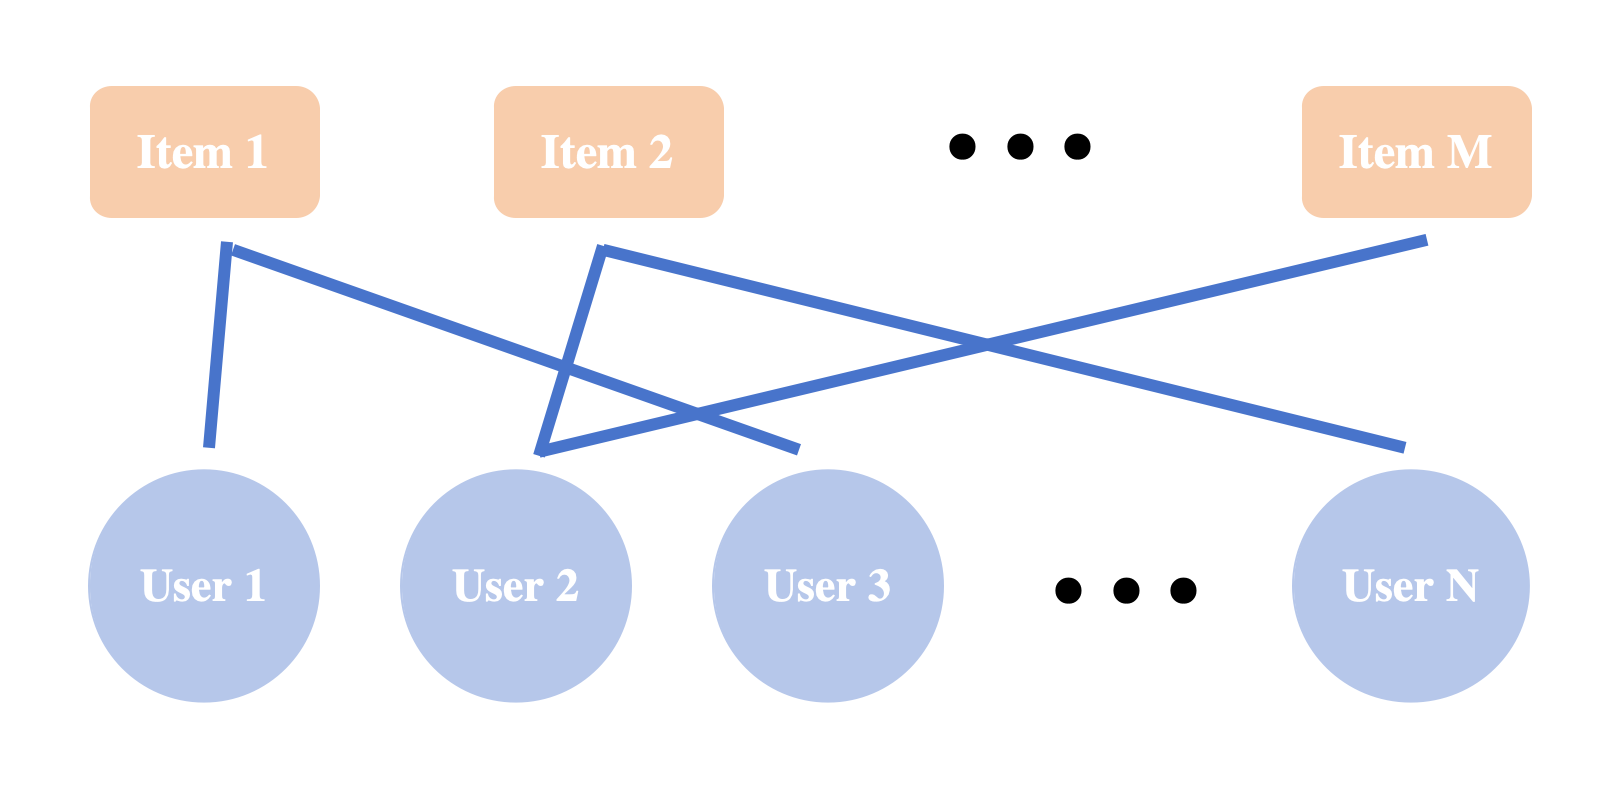

Starting with the initial embeddings $E^{(0)}$ and the bipartite graph, we iterate over each node to perform neighborhood aggregation. Note that LightGCN uses **a simple weighted sum aggregator** and **avoids the heavy-lifting feature transformation and nonlinear activation**.

Within each layer, for each user in the graph, we compute its updated embedding as the weighted sum of embeddings from all its neighboring items following the formula below:
$$ \textbf{e}_u^{(k+1)} = \sum_{i \in N_u} \frac{1}{\sqrt{|N_u|} \sqrt{|N_i|}} \textbf{e}_i^{(k)} $$
where $ \textbf{e}_u^{(k)} $ and $ \textbf{e}_i^{(k)} $ are the user and item node embeddings at the k-th layer. $ |N_u| $ and $ |N_i| $ are the user and item nodes’ number of neighbors. For each user, the number of neighbors are the number of items linked with her; while for each item, the number of neighbors are the number of users linked with it.

Similarly, for each item, the updated embedding is computed using weighted sum of its neighboring users:
$$ \textbf{e}_i^{(k+1)} = \sum_{i \in N_i} \frac{1}{\sqrt{|N_i|} \sqrt{|N_u|}} \textbf{e}_u^{(k)} $$

See the figures below for exactly how that weighted sum is computed. Using $\textbf{e}_{(N+2)}^{(k)}$ as an example:

$$ \textbf{e}_{(N+2)}^{(k)} = \frac{1}{2×2} \textbf{e}_2^{(k-1)} + \frac{1}{2×1} \textbf{e}_N^{(k-1)} $$

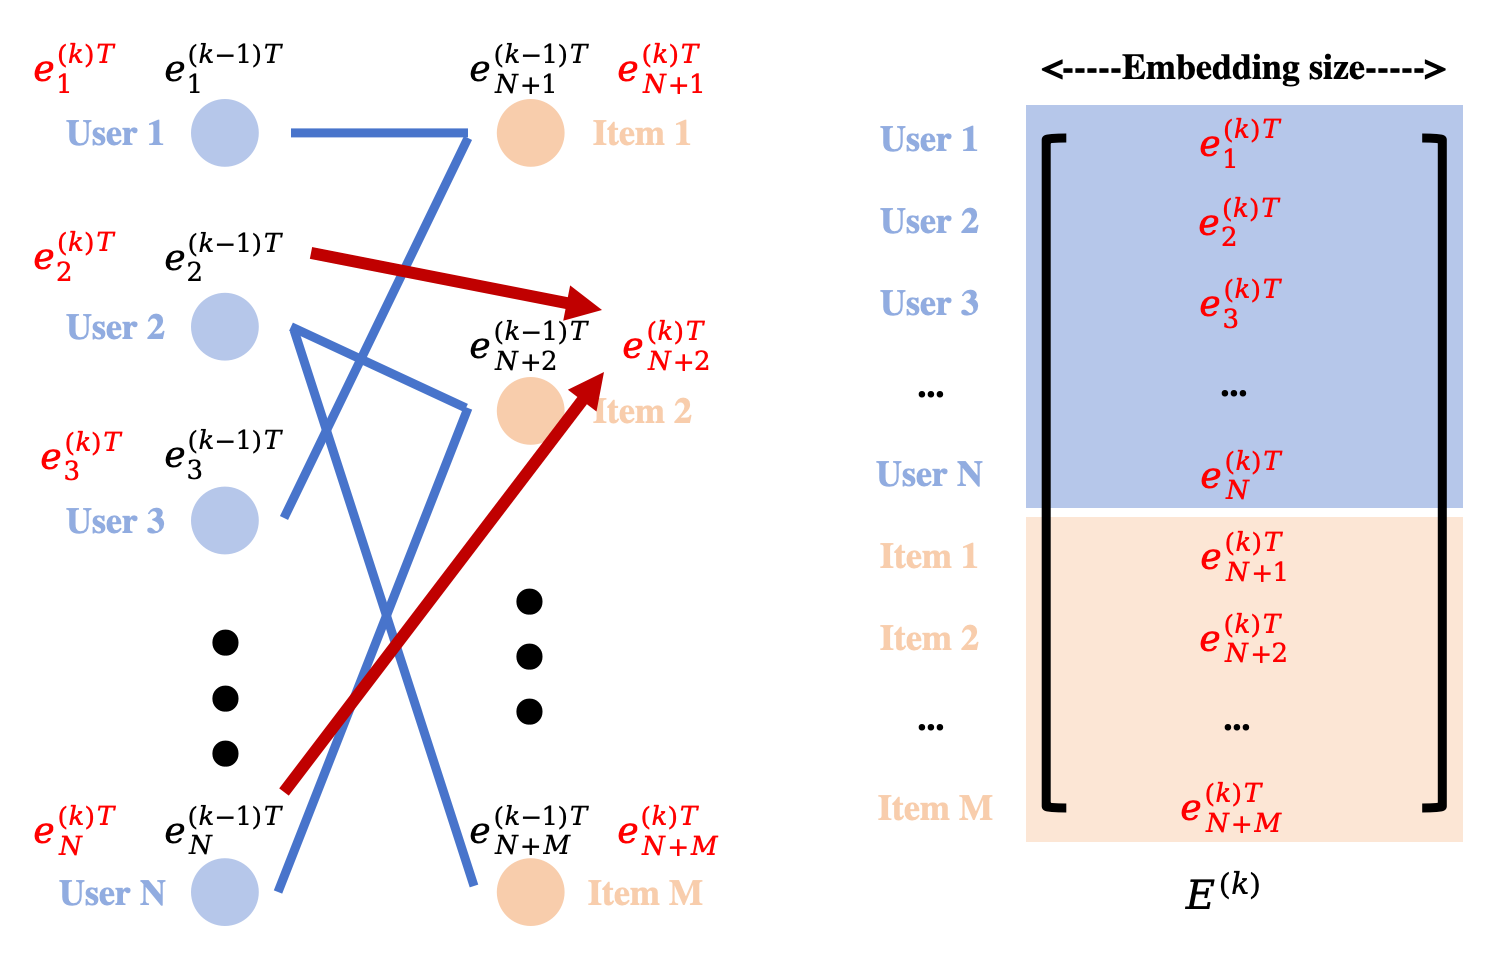

At layer combination, instead of taking the embedding of the final layer, LightGCN computes **a weighted sum of the embeddings at different layers**:
$$ \textbf{e}_u = \sum_{k=0}^K \alpha_k \textbf{e}_u^{(k)} $$
$$ \textbf{e}_i = \sum_{k=0}^K \alpha_k \textbf{e}_i^{(k)} $$
with $ \alpha \ge 0 $. Here, alpha values can either be learned as network parameters, or set as empirical hyperparameters. It has been found that $ \alpha = \frac{1}{K + 1} $ works well.

LightGCN predicts based on the inner product of the final user and item embeddings:
$$ \hat{y}_{ui} = \textbf{e}_u^T \textbf{e}_i $$
This inner product measures the similarity between the user and item, therefore allowing us to understand how likely it is for the user to like the item. Compared to dot product, an inner product is the more general term which can apply to a wide range of different vector spaces.

In [51]:
class LightGCN(nn.Module):
    def __init__(self, data, n_users, n_items, n_layers, latent_dim):
        super(LightGCN, self).__init__()
        self.data = data
        self.n_users = n_users
        self.n_items = n_items
        self.n_layers = n_layers
        self.latent_dim = latent_dim
        self.init_embedding()
        self.norm_adj_mat_sparse_tensor = self.get_A_tilda()

    def init_embedding(self):
        self.E0 = nn.Embedding(self.n_users + self.n_items, self.latent_dim)
        nn.init.xavier_uniform_(self.E0.weight)
        self.E0.weight = nn.Parameter(self.E0.weight)

    def get_A_tilda(self):
        R = sp.dok_matrix((self.n_users, self.n_items), dtype = np.float32)
        R[self.data['user_id_idx'], self.data['item_id_idx']] = self.data['play_frequency']

        # Create adjacency matrix for the user-item graph
        adj_mat = sp.dok_matrix(
                (self.n_users + self.n_items, self.n_users + self.n_items), dtype=np.float32
            )
        adj_mat = adj_mat.tolil()
        R = R.tolil()

        adj_mat[: n_users, n_users :] = R
        adj_mat[n_users :, : n_users] = R.T
        adj_mat = adj_mat.todok()

        # Normalize the adjacency matrix
        rowsum = np.array(adj_mat.sum(1))
        d_inv = np.power(rowsum + 1e-9, -0.5).flatten()
        d_inv[np.isinf(d_inv)] = 0.0
        d_mat_inv = sp.diags(d_inv)
        norm_adj_mat = d_mat_inv.dot(adj_mat)
        norm_adj_mat = norm_adj_mat.dot(d_mat_inv)

        # Convert the dok_matrix to sparse tensor.

        norm_adj_mat_coo = norm_adj_mat.tocoo().astype(np.float32)
        values = norm_adj_mat_coo.data
        indices = np.vstack((norm_adj_mat_coo.row, norm_adj_mat_coo.col))

        i = torch.LongTensor(indices)
        v = torch.FloatTensor(values)
        shape = norm_adj_mat_coo.shape

        norm_adj_mat_sparse_tensor = torch.sparse.FloatTensor(i, v, torch.Size(shape))

        return norm_adj_mat_sparse_tensor

    # propagate user and item embeddings through the network for a specified number of layers
    def propagate_through_layers(self):
        all_layer_embedding = [self.E0.weight]
        E_lyr = self.E0.weight

        for layer in range(self.n_layers):
            E_lyr = torch.sparse.mm(self.norm_adj_mat_sparse_tensor, E_lyr)
            all_layer_embedding.append(E_lyr)

        all_layer_embedding = torch.stack(all_layer_embedding)
        mean_layer_embedding = torch.mean(all_layer_embedding, axis = 0)

        final_user_Embed, final_item_Embed = torch.split(mean_layer_embedding, [n_users, n_items])
        initial_user_Embed, initial_item_Embed = torch.split(self.E0.weight, [n_users, n_items])

        return final_user_Embed, final_item_Embed, initial_user_Embed, initial_item_Embed

    # define the forward pass of the model, compute the final embeddings for given users and items
    def forward(self, users, pos_items, neg_items):
        final_user_Embed, final_item_Embed, initial_user_Embed, initial_item_Embed = self.propagate_through_layers()

        users_emb, pos_emb, neg_emb = final_user_Embed[users], final_item_Embed[pos_items], final_item_Embed[neg_items]
        userEmb0,  posEmb0, negEmb0 = initial_user_Embed[users], initial_item_Embed[pos_items], initial_item_Embed[neg_items]

        return users_emb, pos_emb, neg_emb, userEmb0,  posEmb0, negEmb0

In [52]:
lightGCN = LightGCN(train, n_users, n_items, 3, 256)
print("Size of Learnable Embedding : ", list(lightGCN.parameters())[0].size())

Size of Learnable Embedding :  torch.Size([28378, 256])


## Part 4: Model Traning and Evaluation

We first define the loss function used in training the model as `bpr_loss`. It computes Bayesian Personalized Ranking (BPR) loss and regularization loss:
$$ L_{BPR} = - \sum_{u=1}^M \sum_{i \in N_u} \sum_{j \notin N_u} \ln \sigma(\hat{y}_{ui} - \hat{y}_{uj}) + \lambda ||\textbf{E}^{(0)} ||^2 $$
where $ \textbf{E}^{(0)} $ is a matrix with column vectors being the 0-th layer embeddings to learn. BPR encourages observed user-item predictions to have increasingly higher values than unobserved ones, along with L₂ regularization.
Positive items = Items that the user will interact with in the future.

In [53]:
def bpr_loss(users, users_emb, pos_emb, neg_emb, userEmb0,  posEmb0, negEmb0):
    # Compute regularization loss
    reg_loss = LAMBDA * (userEmb0.norm().pow(2) +
                    posEmb0.norm().pow(2)  +
                    negEmb0.norm().pow(2))

    # Compute scores for positive and negative items
    pos_scores = torch.mul(users_emb, pos_emb)
    pos_scores = torch.sum(pos_scores, dim=1)
    neg_scores = torch.mul(users_emb, neg_emb)
    neg_scores = torch.sum(neg_scores, dim=1)

    # Compute BPR loss using softplus function
    loss = torch.mean(torch.nn.functional.softplus(neg_scores - pos_scores))
    return loss, reg_loss

In [54]:
def data_loader(data, batch_size, n_usr, n_itm):
    # Group interactions by user ID and sample negative items
    interected_items_df = data.groupby('user_id_idx')['item_id_idx'].apply(list).reset_index()

    def sample_neg(x):
        while True:
            neg_id = random.randint(0, n_itm - 1)
            if neg_id not in x:
                return neg_id

    indices = [x for x in range(n_usr)]

    # Randomly select users for batch training
    if n_usr < batch_size:
        users = [random.choice(indices) for _ in range(batch_size)]
    else:
        users = random.sample(indices, batch_size)

    users.sort()

    users_df = pd.DataFrame(users,columns = ['user'])

    interected_items_df = pd.merge(interected_items_df, users_df, how = 'right', left_on = 'user_id_idx', right_on = 'user')

    # Select positive and negative items for each user
    pos_items = interected_items_df['item_id_idx'].apply(lambda x : random.choice(x)).values
    neg_items = interected_items_df['item_id_idx'].apply(lambda x: sample_neg(x)).values

    return list(users), list(pos_items), list(neg_items)

Now we are going to training the model.

Basically, for the training loop, we would consider the following steps:
- Initialize epoch-level variables such as loss and accuracy.
- Split the data into mini-batches and iterate over each batch.
- Forward pass: Pass the input data through the model to compute the predicted outputs.
- Compute the loss between the predicted outputs and the ground truth labels.
- Backward pass: Compute the gradients of the loss with respect to the model parameters.
- Update the model parameters using the optimization algorithm (e.g., gradient descent).
- Optionally, compute and track additional metrics such as accuracy, precision, recall, or F1-score.
- Repeat the above steps for all mini-batches in the training dataset.
- Compute the average loss and metrics for the epoch.

In [55]:
optimizer = torch.optim.Adam(lightGCN.parameters(), lr = 0.003)
EPOCHS = 50
BATCH_SIZE = 128
DECAY = 0.001
K = 30
LAMBDA = 1e-2

In [56]:
loss_list_epoch = []
MF_loss_list_epoch = []
reg_loss_list_epoch = []

recall_list = []
precision_list = []
ndcg_list = []
map_list = []

train_time_list = []
eval_time_list = []

for epoch in tqdm(range(EPOCHS)):
    # Calculate the number of batches per epoch
    n_batch = int(len(train)/BATCH_SIZE)

    # Initialization
    final_loss_list = []
    MF_loss_list = []
    reg_loss_list = []
    best_ndcg = -1
    train_start_time = time.time()

    # Set the model in training mode
    lightGCN.train()

    # Iterate over each batch in the training dataset
    for batch_idx in range(n_batch):
        # Reset gradients
        optimizer.zero_grad()
        # Load data for the current batch
        users, pos_items, neg_items = data_loader(train, BATCH_SIZE, n_users, n_items)
        # Perform forward pass through the model
        users_emb, pos_emb, neg_emb, userEmb0,  posEmb0, negEmb0 = lightGCN.forward(users, pos_items, neg_items)
        # Compute BPR loss and regularization loss
        mf_loss, reg_loss = bpr_loss(users, users_emb, pos_emb, neg_emb, userEmb0,  posEmb0, negEmb0)
        reg_loss = DECAY * reg_loss  # Apply weight decay
        # Combine losses to get the final loss
        final_loss = mf_loss + reg_loss
        # Perform backward pass and update model parameters
        final_loss.backward()
        optimizer.step()
        # Record losses for monitoring
        final_loss_list.append(final_loss.item())
        MF_loss_list.append(mf_loss.item())
        reg_loss_list.append(reg_loss.item())


    train_end_time = time.time()
    train_time = train_end_time - train_start_time

    # model evaluation
    lightGCN.eval()
    with torch.no_grad():
        final_user_Embed, final_item_Embed, initial_user_Embed,initial_item_Embed = lightGCN.propagate_through_layers()
        test_topK_recall,  test_topK_precision, test_topK_ndcg, test_topK_map  = get_metrics(final_user_Embed, final_item_Embed, n_users, n_items, train, test, K)


    eval_time = time.time() - train_end_time

    # calculate and append the mean values of various loss and evaluation metrics for each epoch to their respective lists.
    loss_list_epoch.append(round(np.mean(final_loss_list),4))
    MF_loss_list_epoch.append(round(np.mean(MF_loss_list),4))
    reg_loss_list_epoch.append(round(np.mean(reg_loss_list),4))

    recall_list.append(round(test_topK_recall,4))
    precision_list.append(\
        (test_topK_precision,4))
    ndcg_list.append(round(test_topK_ndcg,4))
    map_list.append(round(test_topK_map,4))

    train_time_list.append(train_time)
    eval_time_list.append(eval_time)

  0%|          | 0/50 [00:00<?, ?it/s]

get the embeddings -- find the relevant scores

In [64]:
final_user_Embed, final_item_Embed, initial_user_Embed,initial_item_Embed = lightGCN.propagate_through_layers()
final_user_Embed

tensor([[ 0.0427,  0.6069,  0.3119,  ..., -0.1675,  0.5131, -0.1776],
        [ 0.4575,  0.1091,  0.2700,  ..., -0.4641, -0.3213,  0.4294],
        [ 0.3472,  0.0778, -0.2984,  ...,  0.3471, -0.4536,  0.0979],
        ...,
        [-0.0477, -0.5443,  0.1931,  ...,  0.2923, -0.1415,  0.1494],
        [ 0.3028, -0.5136, -0.2674,  ..., -0.0816,  0.1545,  0.6965],
        [-0.2287, -0.1068, -0.0892,  ..., -0.8164, -0.3870,  0.6407]],
       grad_fn=<SplitWithSizesBackward0>)

In [65]:
final_item_Embed

tensor([[-0.0962,  0.0164, -0.0019,  ...,  0.0882,  0.0016,  0.0779],
        [-0.0699,  0.0435,  0.1103,  ..., -0.0051,  0.0202,  0.0568],
        [-0.0911,  0.0599,  0.0308,  ...,  0.0198,  0.1152, -0.0542],
        ...,
        [-0.0966, -0.0649, -0.1376,  ...,  0.0618, -0.0250,  0.0835],
        [-0.1137,  0.0091,  0.0648,  ..., -0.0573,  0.0096,  0.0362],
        [ 0.0436,  0.0865, -0.0820,  ..., -0.0374, -0.0791, -0.0714]],
       grad_fn=<SplitWithSizesBackward0>)

In [ ]:
test_topK_recall,  test_topK_precision, test_topK_ndcg, test_topK_map  = get_metrics(final_user_Embed, final_item_Embed, n_users, n_items, train, test, K)

In [67]:
user_Embedding = nn.Embedding(final_user_Embed.size()[0], final_user_Embed.size()[1], _weight = final_user_Embed)
item_Embedding = nn.Embedding(final_item_Embed.size()[0], final_item_Embed.size()[1], _weight = final_item_Embed)

In [90]:
data_ensemble = data_subset[(data_subset['Username'].isin(train_user_ids)) & (data_subset['track'].isin(train_song_ids))]

In [78]:
test_data_user_ids = torch.LongTensor(test['user_id_idx'].unique())
# Compute relevance score matrix based on user and item embeddings
relevance_score = torch.matmul(final_user_Embed, torch.transpose(final_item_Embed,0, 1))
R = sp.dok_matrix((n_users, n_items), dtype = np.float32)
R[train['user_id_idx'], train['item_id_idx']] = train['play_frequency']
R_tensor = convert_to_sparse_tensor(R)
R_tensor_dense = R_tensor.to_dense()
R_tensor_dense = R_tensor_dense*(-np.inf)
R_tensor_dense = torch.nan_to_num(R_tensor_dense, nan=0.0)
relevance_score = relevance_score + R_tensor_dense
relevance_score

tensor([[-1.3590,  0.8743,  1.4313,  ..., -0.4129,  0.7300,  0.1997],
        [ 2.7193, -0.4827, -0.5451,  ..., -0.1486, -0.1036, -0.5962],
        [ 1.0154,  0.0452, -0.8079,  ...,  0.4917, -0.3094,  0.1914],
        ...,
        [-1.0269,  0.1945,  0.4977,  ...,  0.2148,  0.0154, -0.7024],
        [ 0.7760, -0.9898, -0.5128,  ...,  0.0538,  0.4931, -0.4892],
        [-0.0665, -0.5461,  0.1551,  ...,  0.4667,  0.2729,  0.3603]],
       grad_fn=<AddBackward0>)

In [81]:
train

,Username,Top_50,track,artist,user_rank,play_count,total_user_play_count,play_frequency,user_id_idx,item_id_idx
0,toasted_cookies,"(Svrf Party, Lingua Nada, 48, 70)",Svrf Party,Lingua Nada,48,70,5702,0.012276,930,20923
1,paulbruh,"(The Big Foist, Minutemen, 21, 132)",The Big Foist,Minutemen,21,132,6771,0.019495,790,21591
2,shins_fan09,"(Help I'm Alive, Metric, 16, 91)",Help I'm Alive,Metric,16,91,4382,0.020767,851,9765
3,t3hPhazonDragon,"(Colors, Tobu, 21, 108)",Colors,Tobu,21,108,5148,0.020979,897,4652
4,Hizzer-,"(Settle, Vera Blue, 50, 154)",Settle,Vera Blue,50,154,10132,0.015199,142,19028
...,...,...,...,...,...,...,...,...,...,...
39875,elenktra,"(Send to Robin Immediately, Robyn, 21, 202)",Send to Robin Immediately,Robyn,21,202,10606,0.019046,537,18953
39876,palkopupa,"(Guilty, Marina, 17, 468)",Guilty,Marina,17,468,26943,0.01737,786,9191
39877,warjhybrid1,"(JUST LIKE WE NEVER SAID GOODBYE, Sophie, 20, 34)",JUST LIKE WE NEVER SAID GOODBYE,Sophie,20,34,1745,0.019484,963,11749
39878,charispayne,"(iT, Christine and the Queens, 16, 59)",iT,Christine and the Queens,16,59,2943,0.020048,469,26275


In [83]:
train_song_ids

array(['Svrf Party', 'The Big Foist', "Help I'm Alive", ...,
       'JUST LIKE WE NEVER SAID GOODBYE', 'iT', 'Shiawasenarisu'],
      dtype=object)

In [85]:
df_songs = pd.read_csv('../Data/songs_with_similarities.csv')
df_songs = df_songs.loc[df_songs['track_name'].isin(train_song_ids)]
df_songs

,track_name,artist_name,PC1,PC2,PC3,PC4,PC5,PC6,Track_Name_1,Artist_Name_1,...,Similarity_2,Track_Name_3,Artist_Name_3,Similarity_3,Track_Name_4,Artist_Name_4,Similarity_4,Track_Name_5,Artist_Name_5,Similarity_5
0,Cradle,Mudvayne,-2.433464,-0.060096,-0.535616,0.704850,1.418248,-0.565576,Neon Memories,death's dynamic shroud,...,0.900769,Face 2 Face,Juice WRLD,0.895842,Prayer to God,Shellac,0.882166,Knock You Out,Bingo Players,0.875085
2,The Games We Play,Pusha T,-1.501488,-0.982629,-1.068660,0.599166,-0.823863,0.362334,Sleeping Sun,Nightwish,...,0.903053,Mothers Talk,Tears for Fears,0.892954,Painkiller,Beach Bunny,0.888413,This Girl (Kungs Vs. Cookin' On 3 Burners),Kungs,0.888163
4,GODS,"League of Legends, NewJeans",-0.352294,-1.510513,0.264336,0.541752,-0.954476,0.284956,Gun Without Bullets,The Bronx,...,0.881265,Aching,Mannequin Pussy,0.854205,"Hello, I Love You",Adore Delano,0.844723,I Got This,Jennifer Hudson,0.844215
5,Starry Eyes,Mötley Crüe,-0.960875,-0.519723,-0.284011,0.256902,-1.174270,1.062265,Navajo,Black Lips,...,0.843210,Waitress in the Sky,The Replacements,0.830917,Arachnophobia,Meth Wax,0.827884,Come to the Fore,Fellini Félin,0.826773
7,Dreamer,Abakus,-2.948734,2.143075,0.223672,0.995845,-0.397390,0.321396,Voice,Pay money To my Pain,...,0.906928,Ruins Of The Future,Borknagar,0.903455,Dark Desert,Shokran,0.885508,Gary,Speedy Ortiz,0.880445
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
129866,The Show,Girls Aloud,-0.918846,-1.441011,-0.724651,0.048151,0.078764,0.225197,Quoth The Raven,Eluveitie,...,0.892171,Death Blooms,Mudvayne,0.879851,The Afterman,Coheed and Cambria,0.874997,She's so High - 2012 Remaster,Blur,0.870665
129873,I Don't Belong,Fontaines D.C.,-1.876056,-0.141818,-0.678385,0.377098,-0.449902,-0.182002,One of My Lies,Green Day,...,0.904395,The Tenure Itch,The Pains of Being Pure at Heart,0.896685,Untouchable,Pusha T,0.889174,How Does It Feel,D. Savage,0.889082
129876,Between Your Lines,"Chunk! No, Captain Chunk!",0.640707,-2.043371,0.192535,0.442546,0.558846,1.192917,In Honour of Reason,Fleshgod Apocalypse,...,0.946658,The Perpetual Horrors,Naglfar,0.933479,Everlasting Tapeworm,Norma Jean,0.929797,Giant Mantis VS. TURT nip,Heavy Heavy Low Low,0.926648
129877,In Joy And Sorrow,HIM,-1.196585,-0.424149,-1.016421,0.085929,-0.377856,1.200837,Mote,Sonic Youth,...,0.850824,Green Typewriters,The Olivia Tremor Control,0.835932,Two Princes,Spin Doctors,0.835557,The Lion's Roar,First Aid Kit,0.834429


In [138]:
synthetic_data = []
for index, row in data_ensemble.iterrows():
    user = row['Username']
    track = row['track']
    artist = row['artist']
    play_frequency = row['play_frequency']
    user_id_idx = row['user_id_idx']
    cos_result = df_songs.loc[(df_songs['track_name'] == track )& (df_songs['artist_name'] == artist)]
    if len(cos_result) == 0:
        continue
    for i in range(1, 6):
        new_track = cos_result[f'Track_Name_{i}'].iloc[0]
        new_artist = cos_result[f'Artist_Name_{i}'].iloc[0]
        interaction = cos_result[f'Similarity_{i}'].iloc[0] * play_frequency
        item_id_idx = data_ensemble['item_id_idx'].loc[(data_ensemble['track'] == new_track) & (data_ensemble['artist'] == new_artist)]
        if len(item_id_idx) == 0:
            continue

        item_id_idx = item_id_idx.iloc[0]
        if len(data_ensemble.loc[(data_ensemble['item_id_idx'] == item_id_idx) & (data_ensemble['user_id_idx'] == user_id_idx)]) > 0:
            continue
        else:
            new_row = {'Username': user, 'track' : track, 'artist': artist, 'user_rank': (50+i), 'play_frequency': interaction, 
                       'play_count': 0,	'total_user_play_count': 0, 'user_id_idx': user_id_idx, 'item_id_idx': item_id_idx}
            synthetic_data += [new_row]		

In [181]:
d_new = pd.DataFrame(synthetic_data)
d_new = d_new.loc[d_new.track.isin(train_song_ids) & d_new.Username.isin(train_song_ids)]
d_new['user_id_idx'] = le_user.transform(d_new['Username'].values)
d_new['item_id_idx'] = le_user.transform(d_new['track'].values)

In [182]:
data_ensemble_combined = pd.concat([train, d_new])
data_ensemble_combined

,Username,Top_50,track,artist,user_rank,play_count,total_user_play_count,play_frequency,user_id_idx,item_id_idx
0,toasted_cookies,"(Svrf Party, Lingua Nada, 48, 70)",Svrf Party,Lingua Nada,48,70,5702,0.012276,930.0,20923.0
1,paulbruh,"(The Big Foist, Minutemen, 21, 132)",The Big Foist,Minutemen,21,132,6771,0.019495,790.0,21591.0
2,shins_fan09,"(Help I'm Alive, Metric, 16, 91)",Help I'm Alive,Metric,16,91,4382,0.020767,851.0,9765.0
3,t3hPhazonDragon,"(Colors, Tobu, 21, 108)",Colors,Tobu,21,108,5148,0.020979,897.0,4652.0
4,Hizzer-,"(Settle, Vera Blue, 50, 154)",Settle,Vera Blue,50,154,10132,0.015199,142.0,19028.0
...,...,...,...,...,...,...,...,...,...,...
39875,elenktra,"(Send to Robin Immediately, Robyn, 21, 202)",Send to Robin Immediately,Robyn,21,202,10606,0.019046,537.0,18953.0
39876,palkopupa,"(Guilty, Marina, 17, 468)",Guilty,Marina,17,468,26943,0.01737,786.0,9191.0
39877,warjhybrid1,"(JUST LIKE WE NEVER SAID GOODBYE, Sophie, 20, 34)",JUST LIKE WE NEVER SAID GOODBYE,Sophie,20,34,1745,0.019484,963.0,11749.0
39878,charispayne,"(iT, Christine and the Queens, 16, 59)",iT,Christine and the Queens,16,59,2943,0.020048,469.0,26275.0


In [79]:
relevance_score.shape

torch.Size([1001, 27377])

In [183]:
test_data_user_ids = torch.LongTensor(test['user_id_idx'].unique())
# Compute relevance score matrix based on user and item embeddings
relevance_score = torch.matmul(final_user_Embed, torch.transpose(final_item_Embed,0, 1))
R = sp.dok_matrix((n_users, n_items), dtype = np.float32)
R[data_ensemble_combined['user_id_idx'], data_ensemble_combined['item_id_idx']] = data_ensemble_combined['play_frequency']
R_tensor = convert_to_sparse_tensor(R)
R_tensor_dense = R_tensor.to_dense()
R_tensor_dense = R_tensor_dense*(-np.inf)
R_tensor_dense = torch.nan_to_num(R_tensor_dense, nan=0.0)
relevance_score = relevance_score + R_tensor_dense
relevance_score

tensor([[-1.3590,  0.8743,  1.4313,  ..., -0.4129,  0.7300,  0.1997],
        [ 2.7193, -0.4827, -0.5451,  ..., -0.1486, -0.1036, -0.5962],
        [ 1.0154,  0.0452, -0.8079,  ...,  0.4917, -0.3094,  0.1914],
        ...,
        [-1.0269,  0.1945,  0.4977,  ...,  0.2148,  0.0154, -0.7024],
        [ 0.7760, -0.9898, -0.5128,  ...,  0.0538,  0.4931, -0.4892],
        [-0.0665, -0.5461,  0.1551,  ...,  0.4667,  0.2729,  0.3603]],
       grad_fn=<AddBackward0>)

In [184]:
K

30

In [165]:
test_interacted_items

,user_id_idx,item_id_idx
0,0,[22887]
1,1,"[16466, 6937, 18123, 25402, 24005]"
2,2,"[7231, 4196, 2034, 14889, 22070, 10262, 16577,..."
3,3,"[13998, 1344, 17336, 22633, 13155]"
4,4,"[23726, 7718, 6506, 3032, 8883]"
...,...,...
949,996,"[17338, 6443, 18788, 5900, 15381]"
950,997,"[10363, 12170, 9463, 20131]"
951,998,[7874]
952,999,[13283]


In [185]:
 # Retrieve the top-K relevance scores and their corresponding indices
topk_relevance_score = torch.topk(relevance_score, K).values
topk_relevance_indices = torch.topk(relevance_score, K).indices

    # Convert top-K relevance indices to a DataFrame
topk_relevance_indices_df = pd.DataFrame(topk_relevance_indices.numpy(),columns =['top_indx_'+str(x+1) for x in range(K)])
topk_relevance_indices_df['user_index'] = topk_relevance_indices_df.index
topk_relevance_indices_df['top_rlvnt_itm'] = topk_relevance_indices_df[['top_indx_'+str(x+1) for x in range(K)]].values.tolist()
topk_relevance_indices_df = topk_relevance_indices_df[['user_index','top_rlvnt_itm']]

    # Group the test set by user ID and retrieve the list of interacted items
test_interacted_items = data_ensemble_combined.groupby('user_id_idx')['item_id_idx'].apply(list).reset_index()

    # Merge the interacted items list with the top-K relevance indices DataFrame
metrics_df = pd.merge(test_interacted_items,topk_relevance_indices_df, how= 'left', left_on = 'user_id_idx',right_on = ['user_index'])
metrics_df['intrsctn_itm'] = [list(set(a).intersection(b)) for a, b in zip(metrics_df.item_id_idx, metrics_df.top_rlvnt_itm)]

    # Compute recall, precision, and hit list metrics
metrics_df['recall'] = metrics_df.apply(lambda x : len(x['intrsctn_itm'])/len(x['item_id_idx']), axis = 1)
metrics_df['precision'] = metrics_df.apply(lambda x : len(x['intrsctn_itm'])/K, axis = 1)


In [188]:
# Check if each recommended item is in the interacted item list
def get_hit_list(item_id_idx, top_rlvnt_itm):
    return [1 if x in set(item_id_idx) else 0 for x in top_rlvnt_itm ]
metrics_df['hit_list'] = metrics_df.apply(lambda x : get_hit_list(x['item_id_idx'], x['top_rlvnt_itm']), axis = 1)

    # Calculate the ideal DCG (IDCG) based on the number of interacted items and the hit list
def get_dcg_idcg(item_id_idx, hit_list):
    idcg  = sum([1 / np.log1p(idx+1) for idx in range(min(len(item_id_idx),len(hit_list)))])
    dcg =  sum([hit / np.log1p(idx+1) for idx, hit in enumerate(hit_list)])
    return dcg/idcg
metrics_df['ndcg'] = metrics_df.apply(lambda x : get_dcg_idcg(x['item_id_idx'], x['hit_list']), axis = 1)

    # Calculate the cumulative sum of hits in the hit list
def get_cumsum(hit_list):
    return np.cumsum(hit_list)
metrics_df['hit_list_cumsum'] = metrics_df.apply(lambda x : get_cumsum(x['hit_list']), axis = 1)

    # Calculate the mean average precision (MAP) for a user
def get_map(item_id_idx, hit_list, hit_list_cumsum):
    return sum([hit_cumsum*hit/(idx+1) for idx, (hit, hit_cumsum) in enumerate(zip(hit_list, hit_list_cumsum))])/len(item_id_idx)
metrics_df['map'] = metrics_df.apply(lambda x : get_map(x['item_id_idx'], x['hit_list'], x['hit_list_cumsum']), axis = 1)
 

In [189]:
metrics_df['recall'].mean(), metrics_df['precision'].mean(), metrics_df['ndcg'].mean(), metrics_df['map'].mean()

(0.0, 0.0, 0.0, 0.0)

In [190]:
metrics_df

,user_id_idx,item_id_idx,user_index,top_rlvnt_itm,intrsctn_itm,recall,precision,hit_list,ndcg,hit_list_cumsum,map
0,0.0,"[23351.0, 12344.0, 15778.0, 3692.0, 10132.0, 2...",0,"[11403, 9559, 754, 10986, 15913, 26275, 16065,...",[],0.0,0.0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.0
1,1.0,"[8782.0, 7231.0, 1193.0, 7448.0, 25788.0, 2175...",1,"[17794, 9481, 16466, 3241, 24565, 12103, 23700...",[],0.0,0.0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.0
2,2.0,"[14883.0, 5350.0, 7685.0, 15224.0, 14167.0, 12...",2,"[24564, 16577, 14843, 3241, 224, 17794, 1905, ...",[],0.0,0.0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.0
3,3.0,"[13749.0, 22656.0, 1341.0, 14763.0, 20512.0, 7...",3,"[9391, 10300, 5915, 19953, 24007, 8795, 19055,...",[],0.0,0.0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.0
4,4.0,"[1567.0, 23779.0, 5884.0, 5043.0, 18123.0, 117...",4,"[12408, 6320, 26415, 20639, 3135, 10393, 15535...",[],0.0,0.0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.0
...,...,...,...,...,...,...,...,...,...,...,...
996,996.0,"[22785.0, 8309.0, 10722.0, 24227.0, 14467.0, 6...",996,"[24565, 24455, 4188, 25468, 72, 19199, 20201, ...",[],0.0,0.0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.0
997,997.0,"[19711.0, 19860.0, 16036.0, 13959.0, 17150.0, ...",997,"[21987, 22917, 23387, 17827, 18660, 12006, 224...",[],0.0,0.0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.0
998,998.0,"[21861.0, 2989.0, 1798.0, 2555.0, 19963.0, 134...",998,"[7592, 1941, 21014, 5369, 4213, 4490, 9719, 50...",[],0.0,0.0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.0
999,999.0,"[4487.0, 22938.0, 17869.0, 17568.0, 4540.0, 12...",999,"[11712, 7786, 19617, 15384, 2790, 10572, 26311...",[],0.0,0.0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.0


At last, we visualize the performance the model.

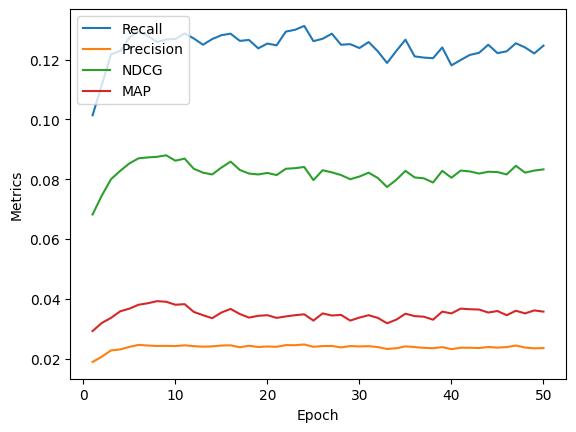

In [66]:
epoch_list = [(i+1) for i in range(EPOCHS)]
plt.plot(epoch_list, recall_list, label='Recall')
plt.plot(epoch_list, [i[0] for i in precision_list], label='Precision')
plt.plot(epoch_list, ndcg_list, label='NDCG')
plt.plot(epoch_list, map_list, label='MAP')
plt.xlabel('Epoch')
plt.ylabel('Metrics')
plt.legend()

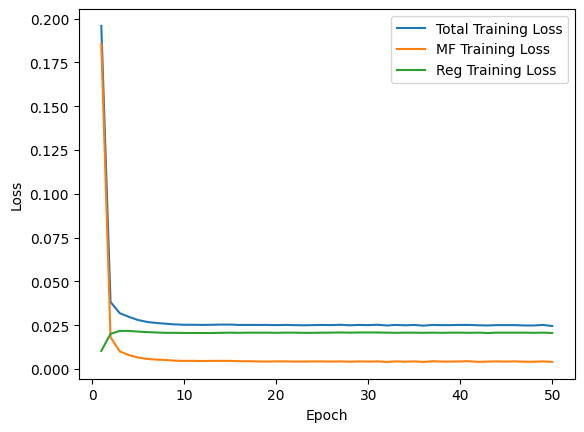

In [58]:
plt.plot(epoch_list, loss_list_epoch, label='Total Training Loss')
plt.plot(epoch_list, MF_loss_list_epoch, label='MF Training Loss')
plt.plot(epoch_list, reg_loss_list_epoch, label='Reg Training Loss')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

In [59]:
print("Last Epoch's Test Data Recall -> ", recall_list[-1])
print("Last Epoch's Test Data Precision -> ", precision_list[-1])
print("Last Epoch's Test Data NDCG -> ", ndcg_list[-1])
print("Last Epoch's Test Data MAP -> ", map_list[-1])

print("Last Epoch's Train Data Loss -> ", loss_list_epoch[-1])

Last Epoch's Test Data Recall ->  0.1247
Last Epoch's Test Data Precision ->  (0.023515024458420686, 4)
Last Epoch's Test Data NDCG ->  0.0833
Last Epoch's Test Data MAP ->  0.0357
Last Epoch's Train Data Loss ->  0.0246
